In [3]:
# Essentials
import numpy as np
import pandas as pd
import datetime
import random

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV,LassoCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import xgboost as xgb

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

import os


In [4]:
# Read in the dataset as a dataframe
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
train.shape, test.shape

((1460, 81), (1459, 80))

# EDA

## The Goal

- Each row in the dataset describes the characteristics of a house.
- Our goal is to predict the SalePrice, given these features.

In [3]:
# Preview the data we're working with
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## SalePrice: the variable we're trying to predict

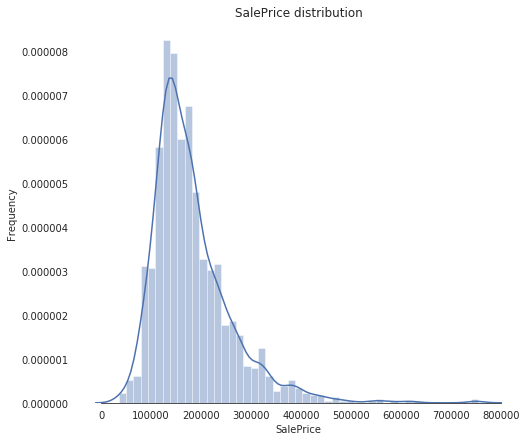

In [4]:
sns.set_style('white')
sns.set_color_codes(palette='deep')
f,ax=plt.subplots(figsize=(8,7))
sns.distplot(train['SalePrice'],color='b')
ax.xaxis.grid(False)
ax.set(ylabel='Frequency')
ax.set(xlabel='SalePrice')
ax.set(title='SalePrice distribution')
sns.despine(trim=True,left=True)
plt.show()

In [5]:
# Skew and kurt
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


## Features: a deep dive

In [6]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


Let's visualize some of the features in the dataset

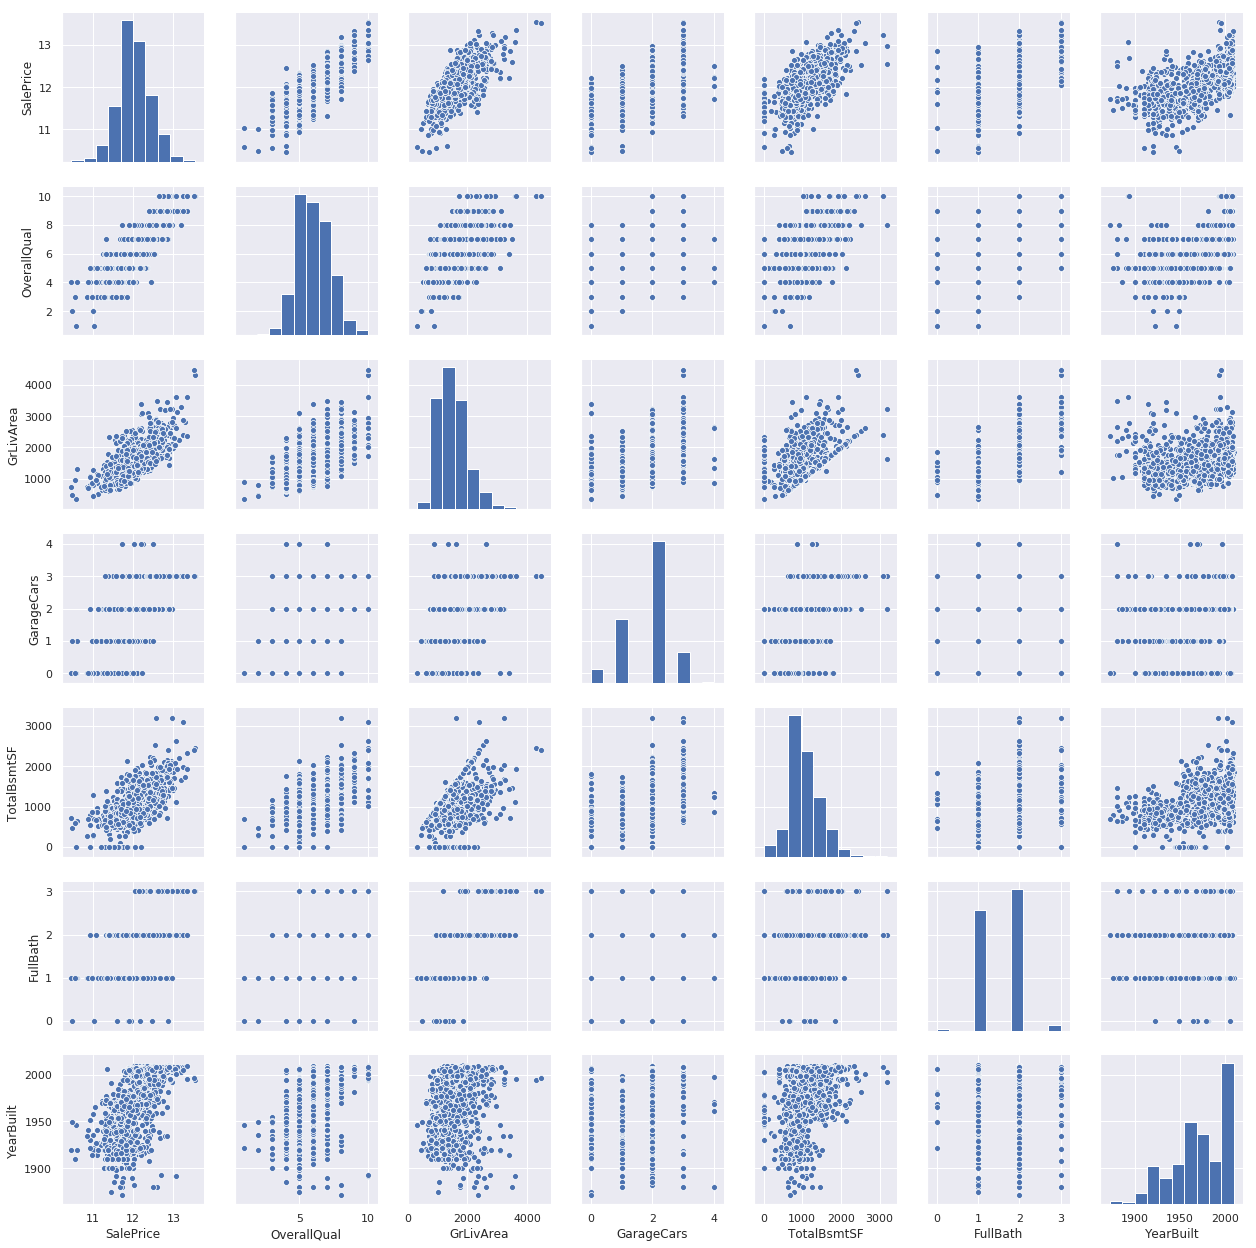

In [136]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show();

and plot how the features are correlated to each other, and to SalePrice

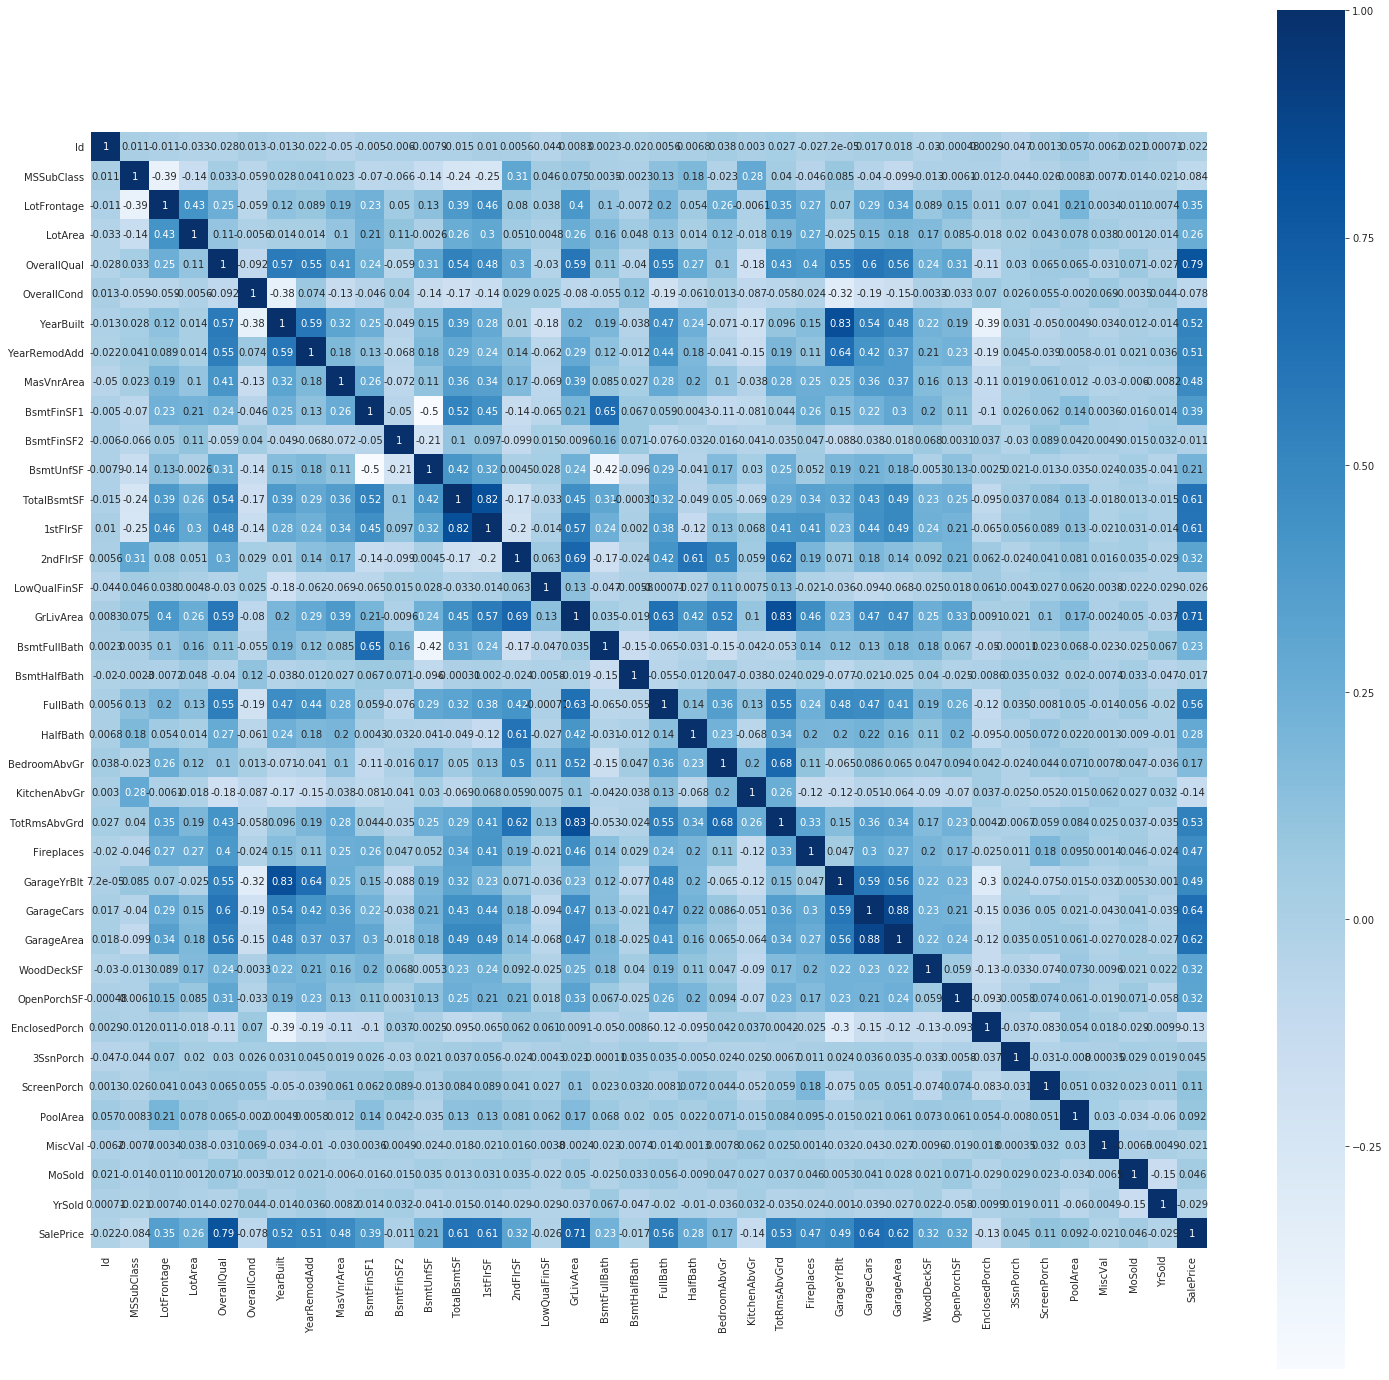

In [8]:
corr = train.corr()
plt.subplots(figsize=(25,25))
sns.heatmap(corr, cmap="Blues", square=True,annot=True)


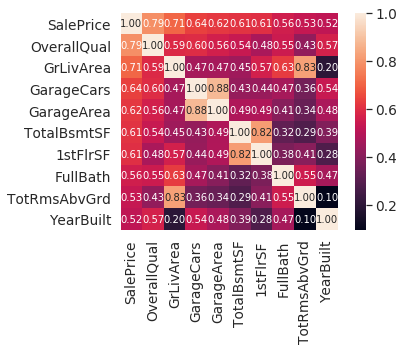

In [9]:
k=10
cols=corr.nlargest(k,'SalePrice')['SalePrice'].index
cm=np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()


Let's plot how SalePrice relates to some of the features in the dataset

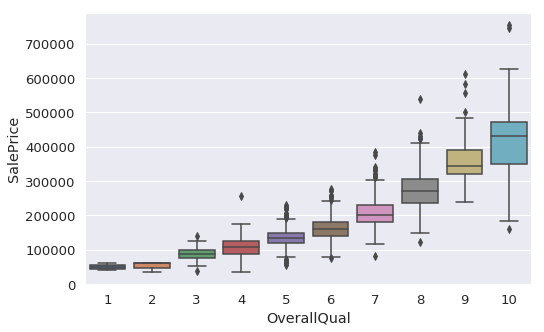

In [10]:
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
sns.boxplot(y=train['SalePrice'], x=train['OverallQual'])

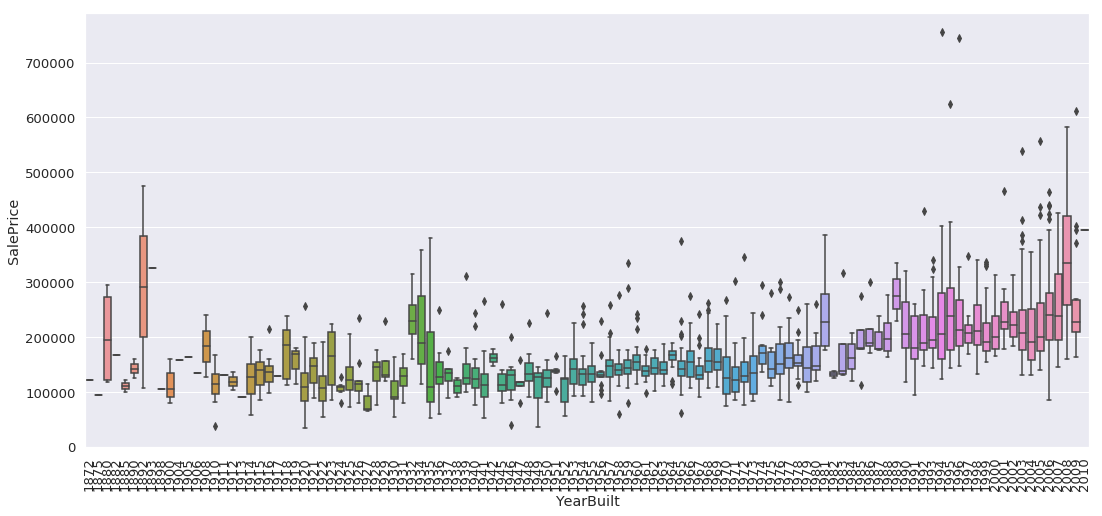

In [11]:
plt.figure(figsize=(18,8))
sns.boxplot(x=train['YearBuilt'], y=train["SalePrice"])
plt.xticks(rotation=90);

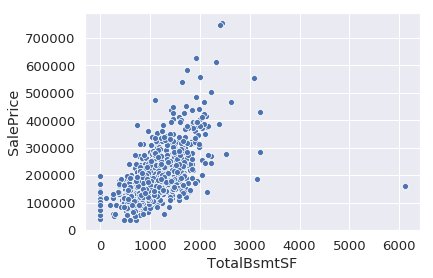

In [12]:
sns.scatterplot(train['TotalBsmtSF'],train['SalePrice'])

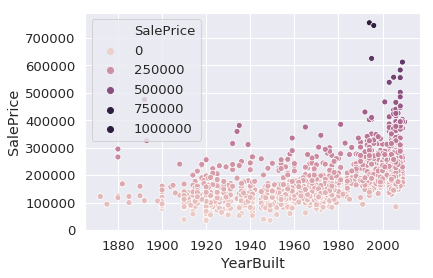

In [13]:
sns.scatterplot(x=train['YearBuilt'],y=train['SalePrice'],hue=train['SalePrice'])

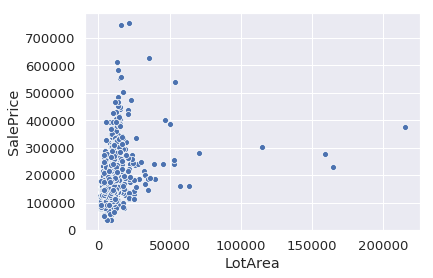

In [14]:
sns.scatterplot(train['LotArea'],train['SalePrice']);

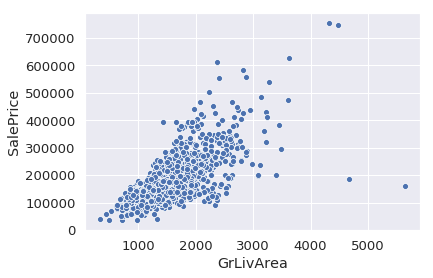

In [15]:
sns.scatterplot(train['GrLivArea'],train['SalePrice'])


In [5]:
# Remove the Ids from train and test, as they are unique for each row and hence not useful for the model
train_ID = train['Id']
test_ID = test['Id']
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)
train.shape, test.shape


((1460, 80), (1459, 79))

# Feature Engineering

Let's take a look at the distribution of the SalePrice.

The SalePrice is skewed to the right. This is a problem because most ML models don't do well with non-normally distributed data. We can apply a log(1+x) tranform to fix the skew.

In [6]:
# log(1+x) transform
train["SalePrice"] = np.log1p(train["SalePrice"])

Let's plot the SalePrice again.


 mu = 12.02 and sigma = 0.40



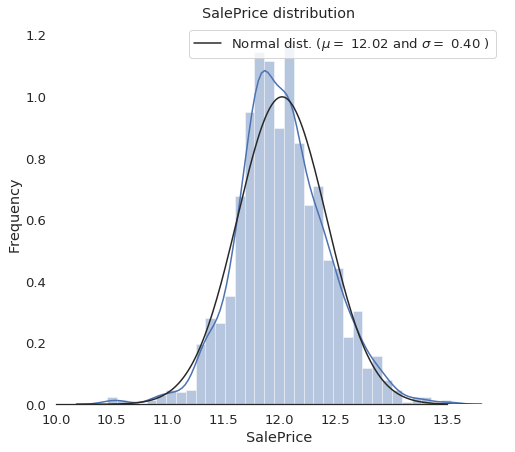

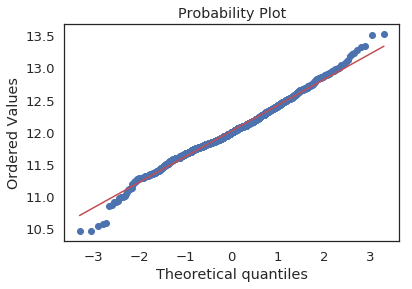

In [18]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm, color="b");

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))


plt.legend(['Normal dist. ($\mu=)'])

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)

plt.show()

from scipy import stats
fig=plt.figure()
res=stats.probplot(train['SalePrice'],plot=plt)
plt.show()

In [7]:
# Remove outliers
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace=True)
train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<300000)].index, inplace=True)
train.reset_index(drop=True, inplace=True)


In [8]:
# Split features and labels
train_labels = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape


(2917, 79)

## Fill missing values

In [9]:
# determine the threshold for missing values
all_data_na = (all_features.isnull().sum() / len(all_features)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageFinish,5.450806
GarageYrBlt,5.450806
GarageQual,5.450806
GarageCond,5.450806


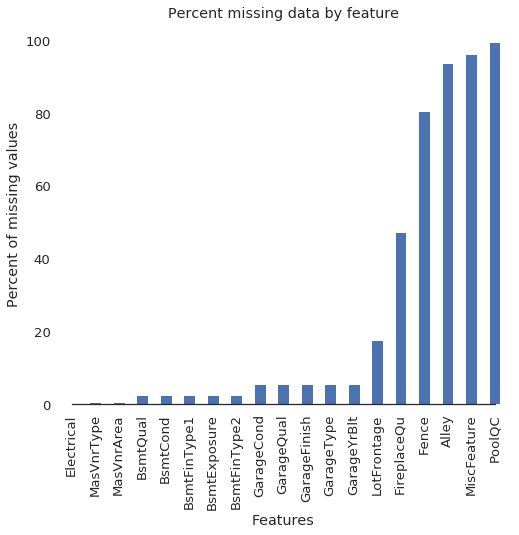

In [22]:
# Visualize missing values
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
sns.set_color_codes(palette='deep')
missing = round(train.isnull().mean()*100,2)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color="b")
# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Percent of missing values")
ax.set(xlabel="Features")
ax.set(title="Percent missing data by feature")
sns.despine(trim=True, left=True)

We can now move through each of the features above and impute the missing values for each of them.

In [10]:
# Some of the non-numeric predictors are stored as numbers; convert them into strings 
all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['MoSold'] = all_features['MoSold'].astype(str)

In [11]:
def handle_missing(features):
    # the data description states that NA refers to typical ('Typ') values
    features['Functional'] = features['Functional'].fillna('Typ')
    # Replace the missing values in each of the columns below with their mode
    features['Electrical'] = features['Electrical'].fillna("SBrkr")
    features['KitchenQual'] = features['KitchenQual'].fillna("TA")
    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
    features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    # the data description stats that NA refers to "No Pool"
    features["PoolQC"] = features["PoolQC"].fillna("None")
    # Replacing the missing values with 0, since no garage = no cars in garage
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        features[col] = features[col].fillna(0)
    # Replacing the missing values with None
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        features[col] = features[col].fillna('None')
    # NaN values for these categorical basement features, means there's no basement
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        features[col] = features[col].fillna('None')
        
    # Group the by neighborhoods, and fill in missing value by the median LotFrontage of the neighborhood
    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # We have no particular intuition around how to fill in the rest of the categorical features
    # So we replace their missing values with None
    
    objects = [i for i in features.columns if features[i].dtype == object]
    features.update(features[objects].fillna('None'))
        
    # And we do the same thing for numerical features, but this time with 0s
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = [i for i in features.columns if features[i].dtype in numeric_dtypes]
    features.update(features[numeric].fillna(0))    
    return features

all_features = handle_missing(all_features)

## Fix skewed features

In [12]:
# Fetch all numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric=all_features.select_dtypes(include=numeric_dtypes).columns

In [13]:
# Find skewed numerical features
skew_features = all_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)


There are 25 numerical features with Skew > 0.5 :


MiscVal          21.939672
PoolArea         17.688664
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
BsmtHalfBath      3.929996
dtype: float64

We use the scipy function boxcox1p which computes the Box-Cox transformation. The goal is to find a simple transformation that lets us normalize data.

In [14]:
# Normalize skewed features
for i in skew_index:
    all_features[i] = boxcox1p(all_features[i], boxcox_normmax(all_features[i] + 1))

In [15]:
all_features.drop(['Street','Utilities'],axis=1)
all_features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,18.144572,13.833055,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,3.991517,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,19.433174,Gd,TA,PConc,Gd,TA,No,GLQ,144.117862,Unf,0.0,29.991052,422.488452,GasA,Ex,Y,SBrkr,5.939033,1025.651978,0.0,8.353544,0.99344,0.000000,2,1.068837,3,0.750957,Gd,2.261968,Typ,0.000000,None,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0.000000,12.080309,0.000000,0.0,0.0,0.0,None,None,None,0.0,2,2008,WD,Normal
1,20,RL,20.673625,14.117918,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,6.000033,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,181.719186,Unf,0.0,44.135410,593.888092,GasA,Ex,Y,SBrkr,6.234989,0.000000,0.0,7.974694,0.00000,0.710895,2,0.000000,3,0.750957,TA,1.996577,Typ,0.903334,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,56.184225,0.000000,0.000000,0.0,0.0,0.0,None,None,None,0.0,5,2007,WD,Normal
2,60,RL,18.668046,14.476513,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,3.991517,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,17.768840,Gd,TA,PConc,Gd,TA,Mn,GLQ,110.441033,Unf,0.0,56.896528,450.079654,GasA,Ex,Y,SBrkr,5.994335,1040.521059,0.0,8.408065,0.99344,0.000000,2,1.068837,3,0.750957,Gd,1.996577,Typ,0.903334,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0.000000,9.901081,0.000000,0.0,0.0,0.0,None,None,None,0.0,9,2008,WD,Normal
3,70,RL,17.249650,14.106197,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,3.991517,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,61.795315,Unf,0.0,64.808848,378.854517,GasA,Gd,Y,SBrkr,6.027703,904.477422,0.0,8.358663,0.99344,0.000000,1,0.000000,3,0.750957,Gd,2.137369,Typ,0.903334,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0.000000,8.966116,16.020712,0.0,0.0,0.0,None,None,None,0.0,2,2006,WD,Abnorml
4,60,RL,21.314282,15.022009,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,3.991517,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,25.404163,Gd,TA,PConc,Gd,TA,Av,GLQ,136.624601,Unf,0.0,61.166371,545.309849,GasA,Ex,Y,SBrkr,6.161220,1273.024862,0.0,8.669322,0.99344,0.000000,2,1.068837,4,0.750957,Gd,2.373753,Typ,0.903334,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,42.245703,14.271569,0.000000,0.0,0.0,0.0,None,None,None,0.0,12,2008,WD,Normal


# Create interesting features

In [16]:
all_features['BsmtFinType1_Unf'] = 1*(all_features['BsmtFinType1'] == 'Unf')
all_features['HasWoodDeck'] = (all_features['WoodDeckSF'] == 0) * 1
all_features['HasOpenPorch'] = (all_features['OpenPorchSF'] == 0) * 1
all_features['HasEnclosedPorch'] = (all_features['EnclosedPorch'] == 0) * 1
all_features['Has3SsnPorch'] = (all_features['3SsnPorch'] == 0) * 1
all_features['HasScreenPorch'] = (all_features['ScreenPorch'] == 0) * 1
all_features['YearsSinceRemodel'] = all_features['YrSold'].astype(int) - all_features['YearRemodAdd'].astype(int)
all_features['Total_Home_Quality'] = all_features['OverallQual'] + all_features['OverallCond']
all_features = all_features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)
all_features['TotalSF'] = all_features['TotalBsmtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']
all_features['YrBltAndRemod'] = all_features['YearBuilt'] + all_features['YearRemodAdd']

all_features['Total_sqr_footage'] = (all_features['BsmtFinSF1'] + all_features['BsmtFinSF2'] +
                                 all_features['1stFlrSF'] + all_features['2ndFlrSF'])
all_features['Total_Bathrooms'] = (all_features['FullBath'] + (0.5 * all_features['HalfBath']) +
                               all_features['BsmtFullBath'] + (0.5 * all_features['BsmtHalfBath']))
all_features['Total_porch_sf'] = (all_features['OpenPorchSF'] + all_features['3SsnPorch'] +
                              all_features['EnclosedPorch'] + all_features['ScreenPorch'] +
                              all_features['WoodDeckSF'])

all_features['TotalBsmtSF'] = all_features['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['2ndFlrSF'] = all_features['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
all_features['GarageArea'] = all_features['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['GarageCars'] = all_features['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
all_features['LotFrontage'] = all_features['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
all_features['MasVnrArea'] = all_features['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
all_features['BsmtFinSF1'] = all_features['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)

all_features['haspool'] = all_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['has2ndfloor'] = all_features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasgarage'] = all_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasbsmt'] = all_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasfireplace'] = all_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

## Feature transformations
Let's create more features by calculating the log and square transformations of our numerical features. We do this manually, because ML models won't be able to reliably tell if log(feature) or feature^2 is a predictor of the SalePrice.

In [17]:
def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)  
        #The addition of 1.01 is intended to handle cases where the original values are zero, preventing issues with the logarithm of zero.
        res.columns.values[m] = l + '_log'
        m += 1
    return res


log_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']

all_features = logs(all_features, log_features)

In [18]:
def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)   
        res.columns.values[m] = l + '_sq'
        m += 1
    return res 

squared_features = ['YearRemodAdd', 'LotFrontage_log', 
              'TotalBsmtSF_log', '1stFlrSF_log', '2ndFlrSF_log', 'GrLivArea_log',
              'GarageCars_log', 'GarageArea_log']
all_features = squares(all_features, squared_features)

## Encode categorical features

Numerically encode categorical features because most models can only handle numerical features.

In [19]:
all_features = pd.get_dummies(all_features).reset_index(drop=True)
all_features.shape

(2917, 379)

In [20]:
all_features.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,BsmtFinType1_Unf,HasWoodDeck,HasOpenPorch,HasEnclosedPorch,Has3SsnPorch,HasScreenPorch,YearsSinceRemodel,Total_Home_Quality,TotalSF,YrBltAndRemod,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,LotFrontage_log,LotArea_log,MasVnrArea_log,BsmtFinSF1_log,BsmtFinSF2_log,BsmtUnfSF_log,TotalBsmtSF_log,1stFlrSF_log,2ndFlrSF_log,LowQualFinSF_log,GrLivArea_log,BsmtFullBath_log,BsmtHalfBath_log,FullBath_log,HalfBath_log,BedroomAbvGr_log,KitchenAbvGr_log,TotRmsAbvGrd_log,Fireplaces_log,GarageCars_log,GarageArea_log,WoodDeckSF_log,OpenPorchSF_log,EnclosedPorch_log,3SsnPorch_log,ScreenPorch_log,PoolArea_log,MiscVal_log,YearRemodAdd_log,TotalSF_log,YearRemodAdd_sq,LotFrontage_log_sq,TotalBsmtSF_log_sq,1stFlrSF_log_sq,2ndFlrSF_log_sq,GrLivArea_log_sq,GarageCars_log_sq,GarageArea_log_sq,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po

In [35]:
all_features.shape

(2917, 379)

In [21]:
# Remove any duplicated column names
all_features = all_features.loc[:,~all_features.columns.duplicated()]

## Recreate training and test sets

In [22]:
X = all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]
X.shape, train_labels.shape, X_test.shape

((1458, 378), (1458,), (1459, 378))

Visualize some of the features we're going to train our models on.

# MODELS


**1. LassoCV (Linear Model with L1 Regularization):**

Advantage: Lasso can perform feature selection, making it useful if some features are irrelevant. It tends to push the coefficients of less important features to zero.

**2. Ridge Regressor (Linear Model with L2 Regularization):**

Advantage: Ridge can handle multicollinearity well and is generally good when you have a large number of features.

**3. XGBoost Regressor (Gradient Boosting):**

Advantage: XGBoost is a powerful ensemble method that can capture complex relationships, handle missing data, and provide feature importance. It's often a strong performer in various scenarios.

**4. Gradient Boosting Regressor:**

Advantage: Gradient Boosting builds trees sequentially, correcting errors of the previous ones. It's robust to outliers and can capture complex relationships.

**5.SVR (Support Vector Regressor):**

Advantage: SVR is good at capturing complex non-linear relationships, especially in high-dimensional spaces. It can handle outliers effectively.

**6. Random Forest Regressor:**

Advantage: Random Forest is an ensemble of decision trees. It's robust, handles non-linear relationships well, and provides feature importance.

**7. LightGBM (Gradient Boosting):**

Advantage: LightGBM is an efficient gradient boosting framework that works well with large datasets. It's faster and requires less memory compared to traditional gradient boosting implementations.

**8.Linear Regression:**

Advantage: Simple linear models can provide a baseline and might be useful if the relationships in your data are predominantly linear.

**9. Bagging Regressor:**

Advantage: Bagging builds multiple instances of a base model and averages their predictions, providing stability and robustness.

**10. Elastic Net (ElasticNetCV):**
Advantage: Elastic Net combines the advantages of Lasso and Ridge by using a combination of L1 and L2 regularization. It can handle feature selection while also addressing multicollinearity.

## K-Fold CV

In [25]:
X_train=X
y_train=train['SalePrice']
cv=KFold(10, random_state=42, shuffle=True).get_n_splits(X_train)
def rmse(model):
    n_folds=10
#     cv=KFold(n_folds, random_state=42, shuffle=True).get_n_splits(X_train)
    rmse_score=np.sqrt(-cross_val_score(model,X_train,y_train,scoring = "neg_mean_squared_error", cv = cv, verbose = -1, n_jobs=-1))
    return(np.mean(rmse_score))

##  1.LINEAR REGRESSION

In [40]:
lr_model=make_pipeline(RobustScaler(),LinearRegression())
lr_model.fit(X_train, y_train)
y_train_pred = lr_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for Linear Regression: {:.3f}".format(rmse(lr_model)))

Mean Squared Error = 0.00713972


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


RMSE score for Linear Regression: 0.124


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.7s finished


Text(0.5, 1.0, 'Prices vs. Predicted Prices')

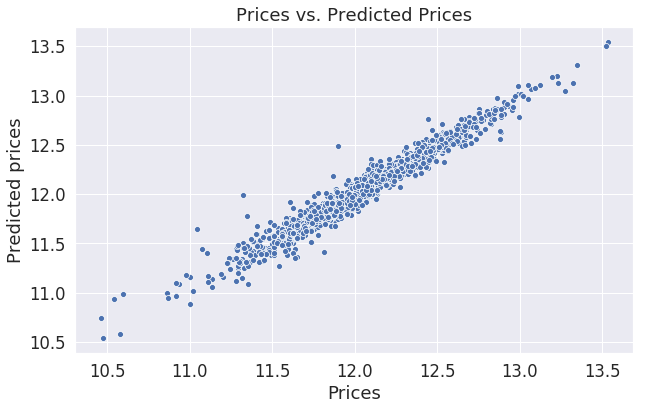

In [41]:
sns.set(font_scale=1.5)
plt.figure(figsize=(10,6))
sns.scatterplot(y_train, y_train_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs. Predicted Prices")

Text(0, 0.5, 'Residuals')

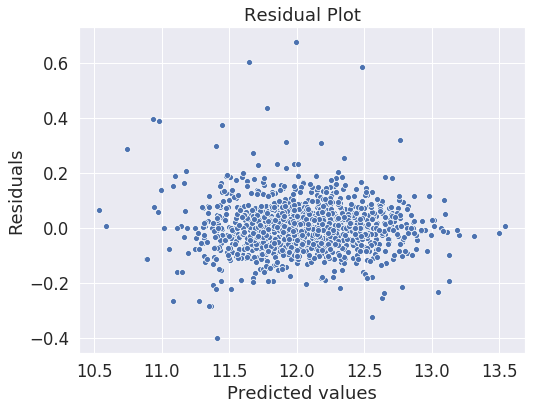

In [42]:
# Residual plot - result should be randomly located around the 0 value
plt.figure(figsize=(8,6))
sns.scatterplot(y_train_pred, y_train_pred - y_train)
plt.title("Residual Plot")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")

## 2. LASSOCV

In [39]:
lasso_model = make_pipeline(RobustScaler(), 
                         LassoCV(alphas = [0.0004, 0.0005, 0.0006],
                                 random_state = 0,
                                 cv = 10))

lasso_model.fit(X_train, y_train)

y_train_pred = lasso_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for LASSO: {:.3f}".format(rmse(lasso_model)))

Mean Squared Error = 0.00938309


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


RMSE score for LASSO: 0.107


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   30.4s finished


In [42]:
print(lasso_model.named_steps['lassocv'].alpha_)

0.0005


<function matplotlib.pyplot.show(*args, **kw)>

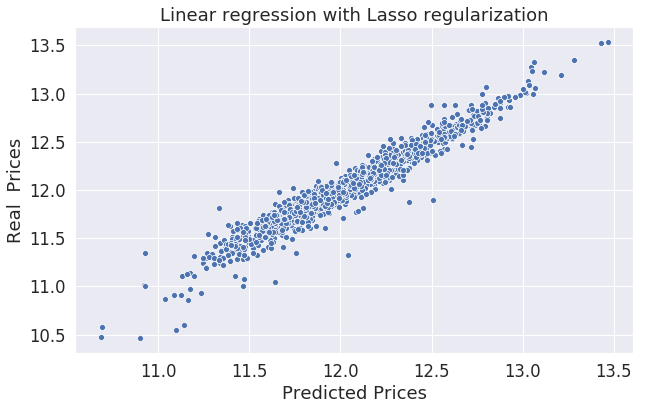

In [48]:
# Plotting predictions
plt.figure(figsize=(10,6))
sns.scatterplot(y_train_pred, y_train)
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted Prices")
plt.ylabel("Real  Prices")
plt.show

## 3. GRADIENT BOOSTING REGRESSOR

In [49]:
gb=GradientBoostingRegressor(random_state=0)
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage used in update to prevent overfitting
    'max_depth': [3, 4, 5],  # Maximum depth of the individual trees
    'min_samples_leaf': [1, 2, 4],  # The minimum number of samples required to be at a leaf node

}
gb_model = GridSearchCV(estimator=gb, param_grid=param_grid, n_jobs=1, cv=10)
gb_model.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...ate=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 4, 5], 'min_samples_leaf': [1, 2, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [50]:
y_train_pred = gb_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)
print('Best Parameters: {}'.format(gb_model.best_params_))
print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for GB: {:.3f}".format(rmse(gb_model)))

Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 2}
Mean Squared Error = 0.00384292


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


RMSE score for GB: 0.122


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 38.6min finished


## 4. XGB REGRESSOR

In [54]:
xgbreg = xgb.XGBRegressor(seed=0)
param_grid2 = { 'n_estimators': [50, 100, 200],  # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage used in update to prevent overfitting
      'gamma': [0, 0.1, 0.2]} # Minimum loss reduction required to make a further partition on a leaf node
    
xgb_model = GridSearchCV(estimator=xgbreg, param_grid=param_grid2, n_jobs=1, cv=10)
xgb_model.fit(X_train, y_train)



GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'gamma': [0, 0.1, 0.2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [55]:
y_train_pred = xgb_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

print('\n\nBest Parameters: {}'.format(xgb_model.best_params_))
print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for XGB: {:.3f}".format(rmse(xgb_model)))



Best Parameters: {'gamma': 0, 'learning_rate': 0.1, 'n_estimators': 200}
Mean Squared Error = 0.00471231


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


RMSE score for XGB: 0.118


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 27.8min finished


## 5. ELASTICNET CV

In [32]:
en_model = ElasticNetCV(alphas = [0.0001, 0.0003, 0.0004, 0.0006], 
                        l1_ratio = [.9, .92], 
                        random_state = 0,
                        cv=10)

In [33]:
en_model.fit(X_train, y_train)

y_train_pred = en_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)
print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for ElasticNet: {:.3f}".format(rmse(en_model)))

Mean Squared Error = 0.00903074


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


RMSE score for ElasticNet: 0.108


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.3min finished


In [44]:
print('Best Params',en_model.alpha_,' ',en_model.l1_ratio_)

Best Params 0.0004   0.92


## 6. LIGHTGBM REGRESSOR

In [58]:
lgb_regressor = lgb.LGBMRegressor(random_state=42)
param_grid = {

    'num_leaves': [20, 30, 40],  # Maximum tree leaves for base learners
    'learning_rate': [0.01, 0.05, 0.1],  # Boosting learning rate
}

# Initialize GridSearchCV
lgb_model = GridSearchCV(estimator=lgb_regressor, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)

# Fit the grid search to the data
lgb_model.fit(X_train, y_train)

# Get the best parameters and best model
best_params = lgb_model.best_params_
best_model = lgb_model.best_estimator_

print("Best Parameters:", best_params)



Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   39.2s finished


Best Parameters: {'learning_rate': 0.1, 'num_leaves': 20}


In [59]:

y_train_pred = lgb_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for LGBMRegressor: {:.4f}".format(rmse(lgb_model)))

Mean Squared Error = 0.00285352


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


RMSE score for LGBMRegressor: 0.1223


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  6.8min finished


## 7. RIDGE REGRESSOR

In [55]:
# Ridge Regressor

ridge_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10,50,100],
}

ridge_regressor = Ridge()

ridge_m = GridSearchCV(ridge_regressor, param_grid=ridge_params, cv=cv)
ridge_m.fit(X_train, y_train)

# Retrieve the best parameters
best_params = ridge_m.best_params_
print("Best Parameters for Ridge:", best_params)



ridge_m.fit(X_train, y_train)

y_train_pred = ridge_m.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)


print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for Ridge: {:.3f}".format(rmse(ridge_m)))


Best Parameters for Ridge: {'alpha': 10}
Mean Squared Error = 0.00855790


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


RMSE score for Ridge: 0.110


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   36.5s finished


In [34]:
print(ridge.named_steps['ridgecv'].alpha_)

10.0


## 8. SUPPORT VECTOR REGRESSOR

In [29]:
# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))
svr.fit(X_train, y_train)

y_train_pred = svr.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

# print("Best alpha : {}", lasso_model.alpha_)
print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for SVR: {:.3f}".format(rmse(svr)))

Mean Squared Error = 0.00736986


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


RMSE score for SVR: 0.108


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.0s finished


## 9. BAGGING REGRESSOR

In [36]:
import sklearn
from sklearn.ensemble import BaggingRegressor

model2 = sklearn.ensemble.BaggingRegressor(base_estimator = en_model, n_estimators = 50, 
                                           max_samples = 30, max_features = 200, verbose = 3, n_jobs = 3)
model2.fit(X_train, y_train)

y_train_pred = model2.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for BaggingRegressor: {:.4f}".format(rmse(model2)))

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Mean Squared Error = 0.02637066


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   19.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


RMSE score for BaggingRegressor: 0.1493


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.7min finished


## 10. RANDOM FOREST REGRESSOR

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search through
param_grid = {
    'max_depth': [10, 20],
    'min_samples_split': [2, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create a RandomForestRegressor
rf_model = RandomForestRegressor(random_state=0)

# Set up GridSearchCV
grid_search = GridSearchCV(rf_model, param_grid=param_grid, cv=cv,n_jobs=3 )

# Fit the grid search to your data
grid_search.fit(X_train, y_train)

# Print the best parameters and corresponding score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Parameters: {'max_depth': 20, 'max_features': 'auto', 'min_samples_split': 5}
Best Score: 0.8709531112023695


In [47]:

y_train_pred = grid_search.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for Random Forest Regressor: {:.4f}".format(rmse(grid_search)))

Mean Squared Error = 0.00471529


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


RMSE score for Random Forest Regressor: 0.1457


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.1min finished


## STACKING

In [56]:
lasso_model = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas = [0.0005],
                              random_state = 42, cv=cv))

elasticnet_model = make_pipeline(RobustScaler(), 
                           ElasticNetCV(max_iter=1e7, alphas=[0.0004], 
                                        cv=cv, l1_ratio=0.92))

lgbm_model = make_pipeline(RobustScaler(),
                        lgb.LGBMRegressor(objective='regression',
                                      learning_rate=0.1,num_leaves=20))

xgboost_model = make_pipeline(RobustScaler(),
                        xgb.XGBRegressor(learning_rate = 0.1, n_estimators=200, 
                                     gamma=0, objective= 'reg:linear'))

gradientboosting_model=make_pipeline(RobustScaler(),
                                   GradientBoostingRegressor (learning_rate=0.1,max_depth=4,
                                                              min_samples_leaf= 2))

svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=[10], cv=cv))

lr_model=make_pipeline(RobustScaler(),LinearRegression())




In [57]:
stack_regressor = StackingCVRegressor(regressors=(lasso_model, elasticnet_model, xgboost_model, lgbm_model,
                                                 gradientboosting_model,svr,ridge,lr_model), 
                               meta_regressor=xgboost_model, use_features_in_secondary=True)

### Fit the models

In [58]:
stack_model = stack_regressor.fit(np.array(X_train),  np.array(y_train))

In [59]:
stack_gen_preds = stack_model.predict(X_test)  

In [95]:
print("RMSE score for Stacked model: {:.4f}".format(rmse(stack_model)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


RMSE score for Stacked model: 0.1093


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  8.4min finished


In [65]:
lasso_model.fit(X_train,y_train)
lasso_pred=lasso_model.predict(X_test)

In [66]:
elasticnet_model.fit(X_train,y_train)
elastic_pred=elasticnet_model.predict(X_test)

In [68]:
xgboost_model.fit(X_train,y_train)
xgbost_pred=xgboost_model.predict(X_test)


In [69]:
lgbm_model.fit(X_train,y_train)
lgbm_pred=lgbm_model.predict(X_test)

In [70]:
gradientboosting_model.fit(X_train,y_train)
gradient_pred=gradientboosting_model.predict(X_test)

In [71]:
svr.fit(X_train,y_train)
svr_pred=svr.predict(X_test)

In [72]:
ridge.fit(X_train,y_train)
ridge_pred=ridge.predict(X_test)

In [73]:
lr_model.fit(X_train,y_train)
lr_pred=lr_model.predict(X_test)

## BLENDING

In [98]:
data = [
    {'Model': 'Lasso', 'Score': 0.107},
    {'Model': 'SVR', 'Score': 0.108},
    {'Model': 'ElasticNet', 'Score': 0.108},
    {'Model': 'Stacked Model', 'Score': 0.1093},
    {'Model': 'Ridge', 'Score': 0.110},
     {'Model': 'XGB', 'Score': 0.118},
    {'Model': 'Gradient Boosting', 'Score': 0.122},
    {'Model': 'LGBMRegressor', 'Score': 0.1223},
    {'Model': 'Linear Regression', 'Score': 0.124},
    {'Model': 'Random Forest Regressor', 'Score': 0.1457},
    {'Model': 'Bagging Regressor', 'Score': 0.1493},
]

scores = pd.DataFrame(data)
scores

,Model,Score
0,Lasso,0.1070
1,SVR,0.1080
2,ElasticNet,0.1080
3,Stacked Model,0.1093
4,Ridge,0.1100
5,XGB,0.1180
6,Gradient Boosting,0.1220
7,LGBMRegressor,0.1223
8,Linear Regression,0.1240
9,Random Forest Regressor,0.1457


In [93]:
stack_preds = ( (0.3*stack_gen_preds)+ (0.15*lasso_pred)+(0.15*svr_pred) + (0.1*elastic_pred)
              + (0.1*ridge_pred)+ (0.05*xgbost_pred)+ (0.05*lgbm_pred)+ (0.05*gradient_pred)
              +(0.05*lr_pred))

In [94]:
predictions_df = pd.DataFrame(np.expm1(stack_preds), 
                              index = X_test.index+1, 
                              columns=["SalePrice"])
predictions_df.index.name = "Id"
predictions_df.head()

,SalePrice
Id,
1459,121846.773779
1460,160422.786633
1461,185816.316139
1462,197871.119301
1463,192997.085212


## Submit predictions

In [131]:
# Read in sample_submission dataframe
submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
submission.shape

(1459, 2)

In [132]:
# Append predictions from blended models
submission.iloc[:,1] = np.floor(np.expm1(stack_preds))

In [133]:

submission.to_csv("submission_regression1.csv", index=False)